<a href="https://colab.research.google.com/github/Dollie1330/daa2-algorithmic-strategies/blob/main/DAA_LAB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install memory profiler (may already exist). It's optional - we use tracemalloc as fallback.
!pip install -q memory_profiler

import time
import random
import itertools
import tracemalloc
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import namedtuple

plt.rcParams['figure.figsize'] = (8,5)
random.seed(0)
os.makedirs("images", exist_ok=True)


In [2]:
# Timing helper (median of repeats)
def time_it(func, *args, repeats=3, **kwargs):
    times=[]
    for _ in range(repeats):
        t0=time.perf_counter()
        res = func(*args, **kwargs)
        t1=time.perf_counter()
        times.append(t1-t0)
    times.sort()
    return times[len(times)//2], res  # return median time and result

# Memory measurement using tracemalloc
def mem_it(func, *args, **kwargs):
    tracemalloc.start()
    func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / (1024*1024)  # MB


In [3]:
# Problem 1: Job Sequencing (Greedy)
Ad = namedtuple("Ad", ["id", "deadline", "profit"])

def schedule_ads(ads):
    """
    ads: list of Ad(id, deadline, profit)
    returns: (selected_ads_list_in_slot_order, total_profit)
    """
    # sort ads by profit descending
    ads_sorted = sorted(ads, key=lambda x: x.profit, reverse=True)
    max_deadline = max((ad.deadline for ad in ads_sorted), default=0)
    slots = [None] * (max_deadline + 1)  # 1..max_deadline used
    total = 0
    selected = []
    for ad in ads_sorted:
        # find a free slot <= deadline
        for s in range(min(max_deadline, ad.deadline), 0, -1):
            if slots[s] is None:
                slots[s] = ad
                total += ad.profit
                selected.append((s, ad))
                break
    # sort selected by slot
    selected_sorted = sorted(selected, key=lambda x: x[0])
    return selected_sorted, total


Selected (slot, ad): [(1, Ad(id='C', deadline=2, profit=27)), (2, Ad(id='A', deadline=2, profit=100)), (3, Ad(id='E', deadline=3, profit=15))]
Total profit: 142


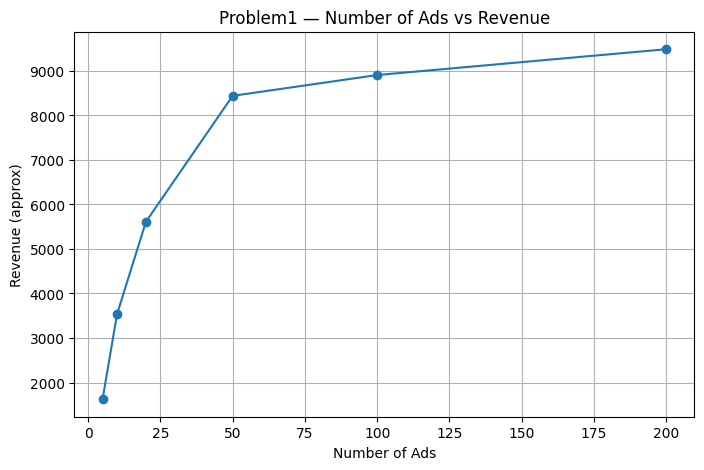

In [4]:
# sample ads
sample_ads = [
    Ad('A', 2, 100),
    Ad('B', 1, 19),
    Ad('C', 2, 27),
    Ad('D', 1, 25),
    Ad('E', 3, 15)
]
sel, tot = schedule_ads(sample_ads)
print("Selected (slot, ad):", sel)
print("Total profit:", tot)

# Experiment: vary number of ads (generate random ads) and plot revenue
def gen_random_ads(n, max_deadline=10, max_profit=200):
    ads=[]
    for i in range(n):
        ads.append(Ad(f"ad{i+1}", random.randint(1,max_deadline), random.randint(1,max_profit)))
    return ads

sizes = [5, 10, 20, 50, 100, 200]
revenues=[]
for s in sizes:
    ads = gen_random_ads(s, max_deadline=20, max_profit=500)
    t, _ = time_it(schedule_ads, ads, repeats=3)
    _, rev = schedule_ads(ads)
    revenues.append(rev)

plt.plot(sizes, revenues, marker='o')
plt.title("Problem1 — Number of Ads vs Revenue")
plt.xlabel("Number of Ads")
plt.ylabel("Revenue (approx)")
plt.grid(True)
plt.savefig("images/problem1_revenue_vs_ads.png")
plt.show()


In [5]:
def knapsack_01(weights, values, capacity):
    """
    bottom-up DP returning max value and chosen items indices
    weights, values: lists of same length
    capacity: int
    returns: (max_value, list_of_selected_item_indices)
    """
    n = len(weights)
    # dp table (n+1) x (capacity+1)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1, n+1):
        w = weights[i-1]; v = values[i-1]
        for c in range(capacity+1):
            if w <= c:
                dp[i][c] = max(dp[i-1][c], dp[i-1][c-w] + v)
            else:
                dp[i][c] = dp[i-1][c]
    # reconstruction
    c = capacity
    chosen=[]
    for i in range(n,0,-1):
        if dp[i][c] != dp[i-1][c]:
            chosen.append(i-1)
            c -= weights[i-1]
    chosen.reverse()
    return dp[n][capacity], chosen


Max value: 7 Chosen indices: [0, 1]


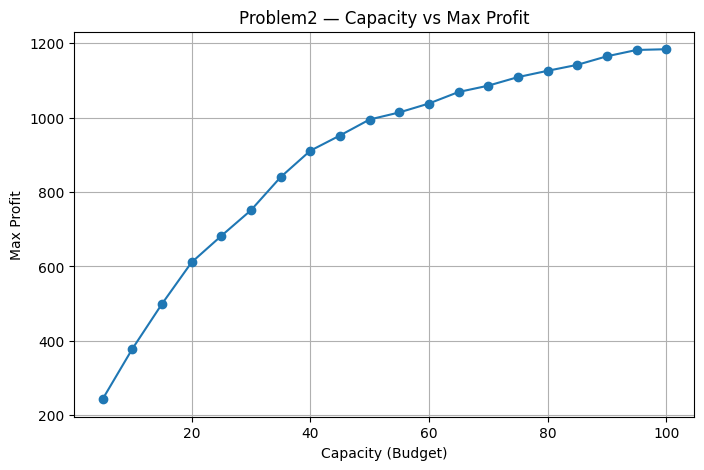

In [6]:
# sample
weights = [2,3,4,5]
values  = [3,4,5,6]
cap = 5
maxv, chosen = knapsack_01(weights, values, cap)
print("Max value:", maxv, "Chosen indices:", chosen)

# Experiment: increase budget (capacity) and plot max profit
def gen_items(n, max_w=20, max_v=100):
    w=[]; v=[]
    for _ in range(n):
        wi = random.randint(1,max_w)
        w.append(wi)
        v.append(random.randint(1,max_v))
    return w,v

n_items = 25
w,v = gen_items(n_items, max_w=10, max_v=100)
capacities = list(range(5, 101, 5))
profits=[]
times=[]
for cap in capacities:
    t, res = time_it(knapsack_01, w, v, cap, repeats=3)
    profits.append(res[0])
    times.append(t)
plt.plot(capacities, profits, marker='o')
plt.title("Problem2 — Capacity vs Max Profit")
plt.xlabel("Capacity (Budget)")
plt.ylabel("Max Profit")
plt.grid(True)
plt.savefig("images/problem2_profit_vs_capacity.png")
plt.show()


In [7]:
# Sudoku solver using backtracking
def find_empty(grid):
    for i in range(9):
        for j in range(9):
            if grid[i][j] == 0:
                return i,j
    return None

def valid(grid, row, col, num):
    # row
    if any(grid[row][c] == num for c in range(9)):
        return False
    # col
    if any(grid[r][col] == num for r in range(9)):
        return False
    # box
    box_r = (row//3)*3
    box_c = (col//3)*3
    for r in range(box_r, box_r+3):
        for c in range(box_c, box_c+3):
            if grid[r][c] == num:
                return False
    return True

def sudoku_solve(grid):
    empty = find_empty(grid)
    if not empty:
        return True
    row, col = empty
    for num in range(1,10):
        if valid(grid, row, col, num):
            grid[row][col] = num
            if sudoku_solve(grid):
                return True
            grid[row][col] = 0
    return False


Solved in (median) seconds: 7.3519999830296e-06
Solution:
[5, 3, 4, 6, 7, 8, 9, 1, 2]
[6, 7, 2, 1, 9, 5, 3, 4, 8]
[1, 9, 8, 3, 4, 2, 5, 6, 7]
[8, 5, 9, 7, 6, 1, 4, 2, 3]
[4, 2, 6, 8, 5, 3, 7, 9, 1]
[7, 1, 3, 9, 2, 4, 8, 5, 6]
[9, 6, 1, 5, 3, 7, 2, 8, 4]
[2, 8, 7, 4, 1, 9, 6, 3, 5]
[3, 4, 5, 2, 8, 6, 1, 7, 9]


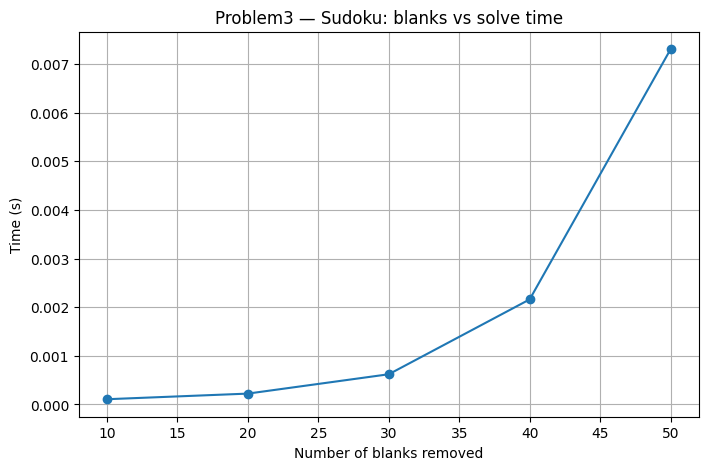

In [8]:
# Sample sudoku puzzle (0 represents blank)
puzzle = [
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
]
import copy
grid = copy.deepcopy(puzzle)
t, _ = time_it(sudoku_solve, grid, repeats=3)
print("Solved in (median) seconds:", t)
print("Solution:")
for row in grid:
    print(row)

# Experiment: measure time vs number of blanks
def count_blanks(g): return sum(1 for r in range(9) for c in range(9) if g[r][c]==0)

# Generate variants by removing k numbers from a solved grid (use solution above)
solved = grid
blank_counts=[]
times=[]
for k in [10,20,30,40,50]:
    # starting from solved puzzle, remove k entries to create a puzzle
    g = [row[:] for row in solved]
    removed=0
    while removed < k:
        i=random.randrange(9); j=random.randrange(9)
        if g[i][j] != 0:
            g[i][j]=0
            removed += 1
    # solve
    t,_ = time_it(lambda x: (sudoku_solve(x), None)[1], g, repeats=1)
    blank_counts.append(k)
    times.append(t)
plt.plot(blank_counts, times, marker='o')
plt.title("Problem3 — Sudoku: blanks vs solve time")
plt.xlabel("Number of blanks removed")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("images/problem3_sudoku_time_vs_blanks.png")
plt.show()


In [9]:
import itertools

def brute_force_crack(target, charset, max_len):
    """
    Try all combinations up to max_len.
    Returns (found_password, attempts)
    """
    attempts = 0
    for length in range(1, max_len+1):
        for comb in itertools.product(charset, repeat=length):
            attempts += 1
            guess = ''.join(comb)
            if guess == target:
                return guess, attempts
    return None, attempts


Len=1 | attempts=1 | time=0.0000s | found=a
Len=2 | attempts=31 | time=0.0000s | found=2a
Len=3 | attempts=213 | time=0.0001s | found=22c
Len=4 | attempts=1027 | time=0.0002s | found=11ca
Len=5 | attempts=3906 | time=0.0006s | found=b23b3


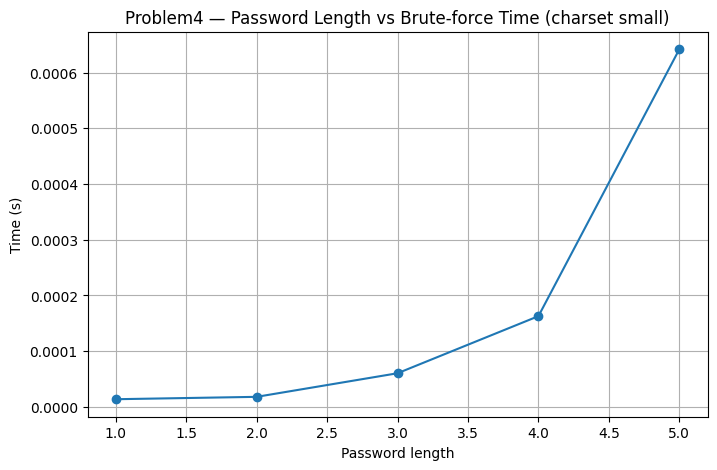

In [10]:
# Choose small charset to keep runs practical
charset = "abc123"
# We'll test random target passwords of length 1..5
lengths = [1,2,3,4,5]
times=[]
attempts_list=[]
for L in lengths:
    target = ''.join(random.choice(charset) for _ in range(L))
    t0=time.perf_counter()
    found, attempts = brute_force_crack(target, charset, max_len=L)
    t1=time.perf_counter()
    times.append(t1-t0)
    attempts_list.append(attempts)
    print(f"Len={L} | attempts={attempts} | time={t1-t0:.4f}s | found={found}")

plt.plot(lengths, times, marker='o')
plt.title("Problem4 — Password Length vs Brute-force Time (charset small)")
plt.xlabel("Password length")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("images/problem4_bruteforce_time_vs_length.png")
plt.show()


In [11]:
print("SUMMARY (basic):")
print("Problem1: Greedy job sequencing. See images/problem1_revenue_vs_ads.png")
print("Problem2: 0/1 Knapsack DP. See images/problem2_profit_vs_capacity.png")
print("Problem3: Sudoku backtracking. See images/problem3_sudoku_time_vs_blanks.png")
print("Problem4: Brute-force password. See images/problem4_bruteforce_time_vs_length.png")


SUMMARY (basic):
Problem1: Greedy job sequencing. See images/problem1_revenue_vs_ads.png
Problem2: 0/1 Knapsack DP. See images/problem2_profit_vs_capacity.png
Problem3: Sudoku backtracking. See images/problem3_sudoku_time_vs_blanks.png
Problem4: Brute-force password. See images/problem4_bruteforce_time_vs_length.png


In [12]:
print("Saved images in /images:")
for f in os.listdir("images"):
    print(" -", f)


Saved images in /images:
 - problem2_profit_vs_capacity.png
 - problem1_revenue_vs_ads.png
 - problem4_bruteforce_time_vs_length.png
 - problem3_sudoku_time_vs_blanks.png
